# **1. Import library**

Menginstall semua depencies yang dibutuhkan

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Text processing and ML libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import TruncatedSVD
import json
import re
import ast
from collections import Counter
import os
import shutil

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# **2. Load Dataset**

In [2]:
def load_data():
    """Load dataset dari file CSV"""
    from google.colab import files
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]
    df = pd.read_csv(filename)

    return df

df = load_data()
print("Dataset berhasil dimuat!")
print(f"Shape: {df.shape}")
print("\nKolom:", df.columns.tolist())

Saving transformed.csv to transformed.csv
Dataset berhasil dimuat!
Shape: (217, 9)

Kolom: ['nama_tempat', 'deskripsi', 'kategori', 'rating', 'jumlah_ulasan', 'alamat', 'link', 'thumbnail', 'gambar']


# **3. Data Wrangling**

In [3]:
# Check for missing values
print("\n❓ Missing Values:")
print(df.isnull().sum())

# Clean and prepare the data
df_clean = df.copy()

# Handle missing values
df_clean['rating'] = df_clean['rating'].fillna(df_clean['rating'].median())
df_clean['jumlah_ulasan'] = df_clean['jumlah_ulasan'].fillna(0)
df_clean['deskripsi'] = df_clean['deskripsi'].fillna('')
df_clean['kategori'] = df_clean['kategori'].fillna('Wisata Alam')

# Clean text data
def clean_text(text):
    if pd.isna(text):
        return ''
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df_clean['deskripsi_clean'] = df_clean['deskripsi'].apply(clean_text)
df_clean['kategori_clean'] = df_clean['kategori'].apply(clean_text)
df_clean['nama_clean'] = df_clean['nama_tempat'].apply(clean_text)

# Extract location information
df_clean['provinsi'] = df_clean['alamat'].str.extract(r'(Sumatera Utara|North Sumatra)')
df_clean['provinsi'] = df_clean['provinsi'].fillna('Sumatera Utara')

print(f"\n✅ Cleaned dataset shape: {df_clean.shape}")
print(f"Unique categories: {df_clean['kategori'].nunique()}")


❓ Missing Values:
nama_tempat      0
deskripsi        0
kategori         0
rating           0
jumlah_ulasan    0
alamat           0
link             0
thumbnail        0
gambar           0
dtype: int64

✅ Cleaned dataset shape: (217, 13)
Unique categories: 41


# **4. EDA**

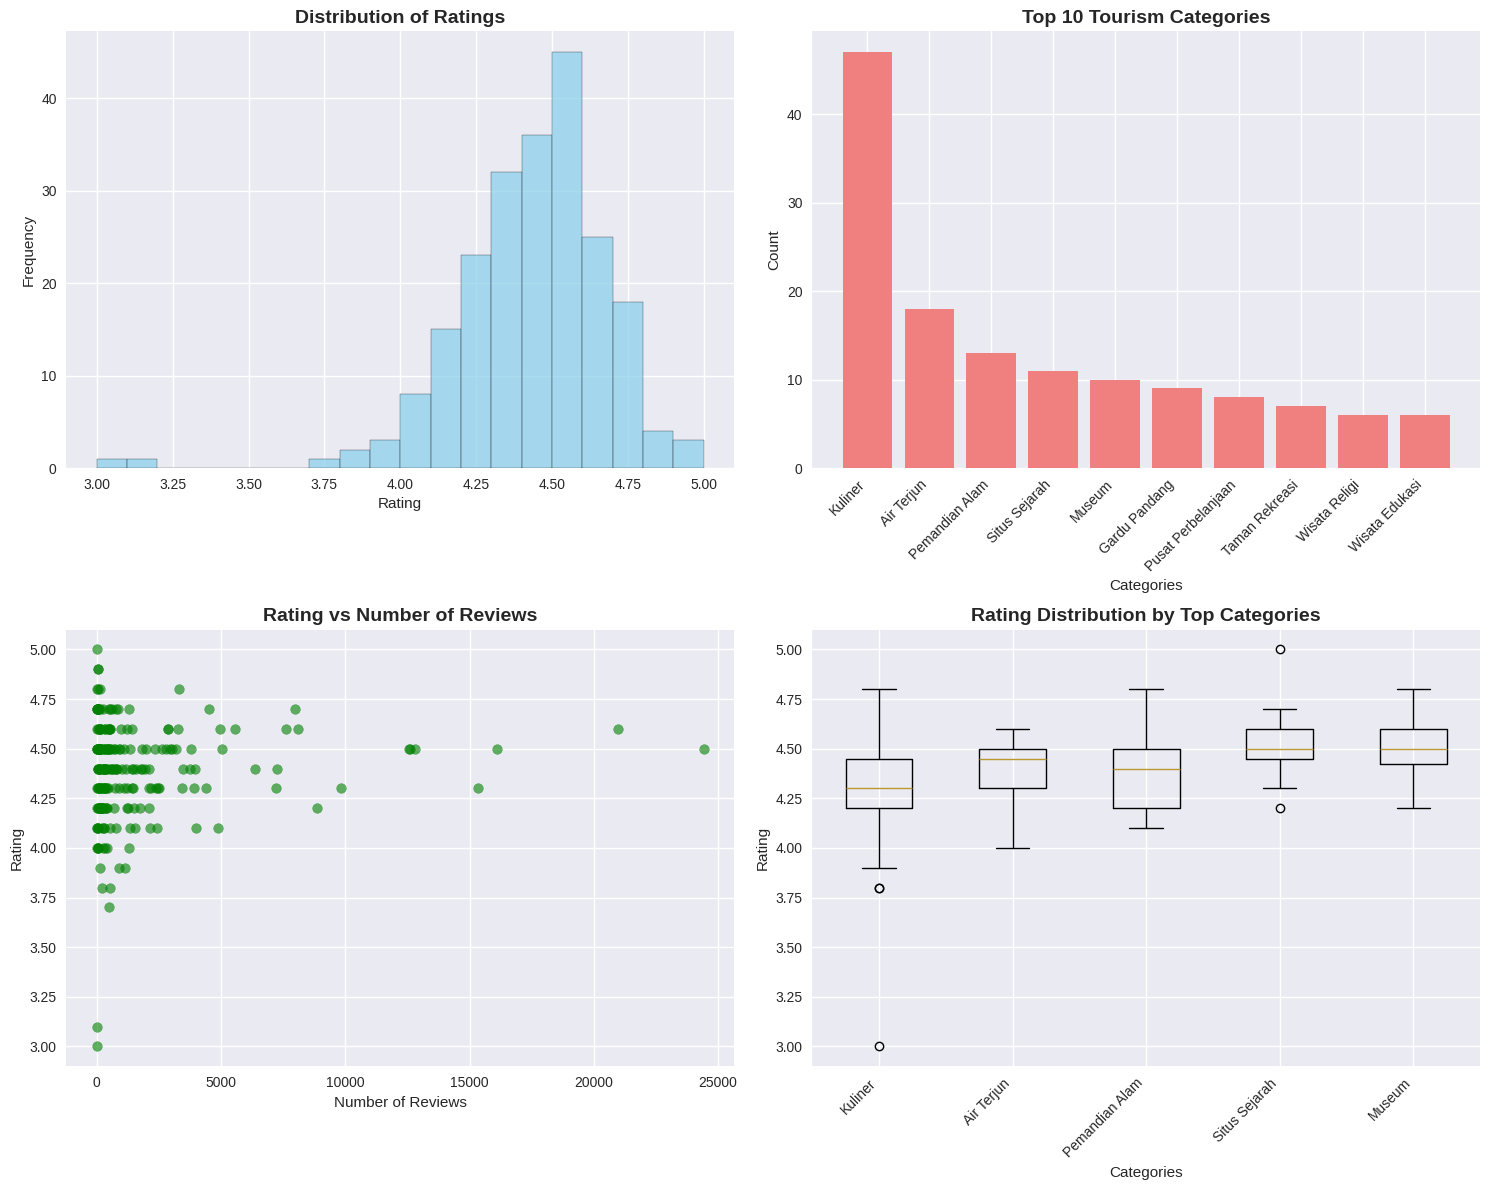


📊 Statistical Summary:
           rating  jumlah_ulasan
count  217.000000     217.000000
mean     4.383871    1669.419355
std      0.254529    3312.727309
min      3.000000       1.000000
25%      4.300000     134.000000
50%      4.400000     442.000000
75%      4.500000    1537.000000
max      5.000000   24427.000000

🏷️ Category Distribution:
kategori
Kuliner               47
Air Terjun            18
Pemandian Alam        13
Situs Sejarah         11
Museum                10
Gardu Pandang          9
Pusat Perbelanjaan     8
Taman Rekreasi         7
Wisata Religi          6
Wisata Edukasi         6
Agrowisata             6
Danau                  6
Pasar Tradisional      5
Taman                  5
Pantai                 5
Monumen                5
Bukit                  4
Wisata Alam            4
Wisata Petualangan     4
Taman Satwa            4
Puncak                 3
Desa Wisata            3
Situs Legenda          2
Gunung                 2
Goa / Ngarai           2
Taman Nasional    

In [4]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Distribution of ratings
axes[0,0].hist(df_clean['rating'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Distribution of Ratings', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Rating')
axes[0,0].set_ylabel('Frequency')

# 2. Categories distribution
category_counts = df_clean['kategori'].value_counts().head(10)
axes[0,1].bar(range(len(category_counts)), category_counts.values, color='lightcoral')
axes[0,1].set_title('Top 10 Tourism Categories', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Categories')
axes[0,1].set_ylabel('Count')
axes[0,1].set_xticks(range(len(category_counts)))
axes[0,1].set_xticklabels(category_counts.index, rotation=45, ha='right')

# 3. Rating vs Number of Reviews
axes[1,0].scatter(df_clean['jumlah_ulasan'], df_clean['rating'], alpha=0.6, color='green')
axes[1,0].set_title('Rating vs Number of Reviews', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Number of Reviews')
axes[1,0].set_ylabel('Rating')

# 4. Rating distribution by category
top_categories = df_clean['kategori'].value_counts().head(5).index
df_top_cat = df_clean[df_clean['kategori'].isin(top_categories)]
axes[1,1].boxplot([df_top_cat[df_top_cat['kategori']==cat]['rating'].values
                   for cat in top_categories])
axes[1,1].set_title('Rating Distribution by Top Categories', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Categories')
axes[1,1].set_ylabel('Rating')
axes[1,1].set_xticklabels(top_categories, rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Statistical summary
print("\n📊 Statistical Summary:")
print(df_clean[['rating', 'jumlah_ulasan']].describe())

print(f"\n🏷️ Category Distribution:")
print(df_clean['kategori'].value_counts())

# **5. Preprocessing**

In [5]:
# Create combined text features for content-based filtering
df_clean['combined_features'] = (
    df_clean['nama_clean'] + ' ' +
    df_clean['deskripsi_clean'] + ' ' +
    df_clean['kategori_clean']
)

# Create popularity score
def calculate_popularity_score(rating, num_reviews):
    # Weighted rating considering number of reviews
    min_reviews = df_clean['jumlah_ulasan'].quantile(0.25)
    return (rating * np.log1p(num_reviews)) / (1 + np.exp(-num_reviews/min_reviews))

df_clean['popularity_score'] = df_clean.apply(
    lambda x: calculate_popularity_score(x['rating'], x['jumlah_ulasan']), axis=1
)

# Normalize popularity score
scaler = MinMaxScaler()
df_clean['popularity_normalized'] = scaler.fit_transform(df_clean[['popularity_score']])

# Create category encoding for hybrid approach
category_encoder = pd.get_dummies(df_clean['kategori'], prefix='cat')
df_features = pd.concat([df_clean, category_encoder], axis=1)

print(f"✅ Feature engineering completed!")
print(f"Combined features sample: {df_clean['combined_features'].iloc[0][:100]}...")

✅ Feature engineering completed!
Combined features sample: wisata alam datuk pantai reklamasi terpanjang di sumatra menawarkan pemandangan indah beragam wahana...


# **6. Feature Extraction and Cosine Similarity**

In [6]:
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=1,
    max_df=0.8
)

# Fit and transform the combined features
tfidf_matrix = tfidf.fit_transform(df_clean['combined_features'])
print(f"TF-IDF Matrix shape: {tfidf_matrix.shape}")

# Calculate cosine similarity matrix
print("🔢 Calculating Cosine Similarity...")
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print(f"Cosine Similarity Matrix shape: {cosine_sim.shape}")

# Create indices mapping
indices = pd.Series(df_clean.index, index=df_clean['nama_tempat']).drop_duplicates()

TF-IDF Matrix shape: (217, 3210)
🔢 Calculating Cosine Similarity...
Cosine Similarity Matrix shape: (217, 217)


# **7. Recommendation Function**

In [7]:
def get_recommendations(place_name, cosine_sim=cosine_sim, df=df_clean, top_n=5):
    """
    Get tourism recommendations based on place name
    """
    try:
        # Get the index of the place
        idx = indices[place_name]

        # Get similarity scores for all places
        sim_scores = list(enumerate(cosine_sim[idx]))

        # Sort places based on similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Get top N similar places (excluding the input place itself)
        sim_scores = sim_scores[1:top_n+1]

        # Get place indices
        place_indices = [i[0] for i in sim_scores]

        # Return recommended places with details
        recommendations = df.iloc[place_indices][['nama_tempat', 'kategori', 'rating',
                                                 'jumlah_ulasan', 'deskripsi', 'alamat']].copy()
        recommendations['similarity_score'] = [i[1] for i in sim_scores]

        return recommendations

    except KeyError:
        print(f"❌ Place '{place_name}' not found in dataset!")
        print("Available places:")
        print(df['nama_tempat'].tolist()[:10])
        return None

def get_popular_recommendations(category=None, top_n=5):
    """
    Get popular tourism recommendations by category
    """
    if category:
        filtered_df = df_clean[df_clean['kategori'].str.contains(category, case=False, na=False)]
    else:
        filtered_df = df_clean

    # Sort by popularity score and rating
    popular_places = filtered_df.nlargest(top_n, ['popularity_normalized', 'rating'])

    return popular_places[['nama_tempat', 'kategori', 'rating', 'jumlah_ulasan',
                          'deskripsi', 'alamat', 'popularity_normalized']]

def hybrid_recommendations(place_name, category_weight=0.3, popularity_weight=0.3,
                          content_weight=0.4, top_n=5):
    """
    Hybrid recommendation combining content-based, category, and popularity
    """
    try:
        idx = indices[place_name]
        target_category = df_clean.iloc[idx]['kategori']

        # Content-based similarity
        content_scores = cosine_sim[idx]

        # Category similarity
        category_sim = np.zeros(len(df_clean))
        category_sim[df_clean['kategori'] == target_category] = 1.0

        # Popularity scores
        popularity_scores = df_clean['popularity_normalized'].values

        # Combine scores
        hybrid_scores = (content_weight * content_scores +
                        category_weight * category_sim +
                        popularity_weight * popularity_scores)

        # Get top recommendations
        sim_scores = list(enumerate(hybrid_scores))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:top_n+1]  # Exclude the input place

        place_indices = [i[0] for i in sim_scores]
        recommendations = df_clean.iloc[place_indices][['nama_tempat', 'kategori', 'rating',
                                                      'jumlah_ulasan', 'deskripsi', 'alamat']].copy()
        recommendations['hybrid_score'] = [i[1] for i in sim_scores]

        return recommendations

    except KeyError:
        print(f"❌ Place '{place_name}' not found!")
        return None

# **8. Evaluation**

In [8]:
def evaluate_diversity(recommendations):
    """Calculate diversity of recommendations based on categories"""
    if recommendations is None or len(recommendations) == 0:
        return 0
    categories = recommendations['kategori'].tolist()
    unique_categories = len(set(categories))
    return unique_categories / len(categories)

def evaluate_novelty(recommendations, popular_threshold=0.7):
    """Calculate novelty by measuring how many non-popular items are recommended"""
    if recommendations is None or len(recommendations) == 0:
        return 0
    if 'popularity_normalized' in recommendations.columns:
        novel_items = len(recommendations[recommendations['popularity_normalized'] < popular_threshold])
        return novel_items / len(recommendations)
    return 0

# Test recommendations
print("\n🧪 Testing Recommendations...")
test_place = df_clean['nama_tempat'].iloc[0]
print(f"Testing with: {test_place}")

# Content-based recommendations
content_recs = get_recommendations(test_place)
print(f"\n📍 Content-based Recommendations for '{test_place}':")
if content_recs is not None:
    print(content_recs[['nama_tempat', 'kategori', 'rating', 'similarity_score']])

# Popular recommendations
popular_recs = get_popular_recommendations(category='Danau')
print(f"\n🔥 Popular 'Danau' Recommendations:")
print(popular_recs[['nama_tempat', 'kategori', 'rating', 'jumlah_ulasan']])

# Hybrid recommendations
hybrid_recs = hybrid_recommendations(test_place)
print(f"\n🎯 Hybrid Recommendations for '{test_place}':")
if hybrid_recs is not None:
    print(hybrid_recs[['nama_tempat', 'kategori', 'rating', 'hybrid_score']])

# Calculate evaluation metrics
if content_recs is not None:
    diversity_score = evaluate_diversity(content_recs)
    print(f"\n📊 Evaluation Metrics:")
    print(f"Diversity Score: {diversity_score:.3f}")
    print(f"Average Rating of Recommendations: {content_recs['rating'].mean():.2f}")
    print(f"Average Similarity Score: {content_recs['similarity_score'].mean():.3f}")


🧪 Testing Recommendations...
Testing with: Wisata Alam Datuk

📍 Content-based Recommendations for 'Wisata Alam Datuk':
                                  nama_tempat        kategori  rating  \
32   Wisata Alam Syaakirah The View and Resto         Kuliner     4.4   
39                      Wisata Alam Sini Suka  Taman Rekreasi     4.1   
16                            Penatapen Doulu   Gardu Pandang     4.5   
50                   Wisata Alam Pantai Geger          Pantai     4.2   
110                       Pantai Bali Lestari          Pantai     4.1   

     similarity_score  
32           0.225490  
39           0.191239  
16           0.184184  
50           0.170782  
110          0.140266  

🔥 Popular 'Danau' Recommendations:
                           nama_tempat kategori  rating  jumlah_ulasan
23                  Danau Toba Parapat    Danau     4.7         4520.0
18                     Danau Lau Kawar    Danau     4.3          910.0
13  TAMAN WISATA DANAU SIOMBAK MARELAN    Danau 

# **9. Save Model**

In [12]:
# Prepare data for JSON export
model_data = {
    'metadata': {
        'model_type': 'Content-Based Tourism Recommendation System',
        'dataset_size': len(df_clean),
        'features_used': ['nama_tempat', 'deskripsi', 'kategori'],
        'similarity_method': 'Cosine Similarity with TF-IDF',
        'categories': df_clean['kategori'].unique().tolist(),
        'date_created': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
    },
    'places_data': [],
    'similarity_matrix_shape': cosine_sim.shape,
    'evaluation_metrics': {
        'diversity_score': diversity_score if 'diversity_score' in locals() else 0,
        'average_rating': float(df_clean['rating'].mean()),
        'total_categories': int(df_clean['kategori'].nunique())
    }
}

os.makedirs("model", exist_ok=True)

# Add places data
for idx, row in df_clean.iterrows():
    place_data = {
        'id': int(idx),
        'nama_tempat': row['nama_tempat'],
        'kategori': row['kategori'],
        'rating': float(row['rating']) if pd.notna(row['rating']) else 0.0,
        'jumlah_ulasan': int(row['jumlah_ulasan']) if pd.notna(row['jumlah_ulasan']) else 0,
        'deskripsi': row['deskripsi'],
        'alamat': row['alamat'],
        'popularity_score': float(row['popularity_normalized']),
        'combined_features': row['combined_features']
    }
    model_data['places_data'].append(place_data)

# Save to JSON
with open('model/tourism_recommendation_model.json', 'w', encoding='utf-8') as f:
    json.dump(model_data, f, ensure_ascii=False, indent=2)

# Save similarity matrix (as it's too large for JSON)
np.save('model/cosine_similarity_matrix.npy', cosine_sim)

# Save TF-IDF vectorizer parameters
tfidf_params = {
    'max_features': 5000,
    'ngram_range': [1, 2],
    'min_df': 1,
    'max_df': 0.8,
    'vocabulary_size': len(tfidf.get_feature_names_out())
}

with open('model/tfidf_parameters.json', 'w') as f:
    json.dump(tfidf_params, f, indent=2)

!pip freeze > model/requirements.txt

print("✅ Model and results saved successfully!")
print("📁 Folders Model created")
print("📁 Files created:")
print("  - tourism_recommendation_model.json")
print("  - cosine_similarity_matrix.npy")
print("  - tfidf_parameters.json")
print("  - requirements.txt")

# Zip folder model menjadi cbf_encoder.zip
shutil.make_archive('model_cbf', 'zip', 'model')

from google.colab import files
files.download('model_cbf.zip')

print("📁 Zip All File to Model_CBF")
print("📁 Download the ZIP")

✅ Model and results saved successfully!
📁 Folders Model created
📁 Files created:
  - tourism_recommendation_model.json
  - cosine_similarity_matrix.npy
  - tfidf_parameters.json
  - requirements.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📁 Zip All File to Model_CBF
📁 Download the ZIP


# **10. Inference**


In [13]:
print("\n🎯 Inference Examples...")

def interactive_recommendation():
    """Interactive recommendation function"""
    print("\n🔍 Available Tourism Places:")
    for i, place in enumerate(df_clean['nama_tempat'].head(10), 1):
        print(f"{i}. {place}")

    print(f"\nTotal places available: {len(df_clean)}")

    # Example recommendations
    example_places = ['Danau Toba Parapat', 'Bukit Indah Simarjarunjung', 'Air Terjun Sikulikap']

    for place in example_places:
        if place in df_clean['nama_tempat'].values:
            print(f"\n🏞️ Recommendations for '{place}':")
            recs = get_recommendations(place, top_n=3)
            if recs is not None:
                for idx, rec in recs.iterrows():
                    print(f"  • {rec['nama_tempat']} ({rec['kategori']}) - Rating: {rec['rating']:.1f}")

interactive_recommendation()

print(f"\n🎉 Tourism Recommendation System Complete!")
print(f"📊 Dataset processed: {len(df_clean)} tourism places")
print(f"🏷️ Categories available: {df_clean['kategori'].nunique()}")
print(f"⭐ Average rating: {df_clean['rating'].mean():.2f}")
print(f"🔤 TF-IDF features: {tfidf_matrix.shape[1]}")
print("="*60)


🎯 Inference Examples...

🔍 Available Tourism Places:
1. Wisata Alam Datuk
2. WISATA ALAM KASIH
3. Taman Wisata Alam Sibolangit
4. Wisata Alam Sikabung-kabung
5. Bukit Indah Simarjarunjung
6. Bukit Sipisopiso
7. Air Terjun Sigura-Gura
8. Taman Alam Lumbini Berastagi
9. Wisata Batu Katak
10. Kawah Putih Dolok Tinggi Raja

Total places available: 217

🏞️ Recommendations for 'Danau Toba Parapat':
  • Danau Lau Kawar (Danau) - Rating: 4.3
  • Manigom Nauli (Desa Wisata) - Rating: 4.4
  • Danau alam jaya tuntungan (Danau) - Rating: 3.1

🏞️ Recommendations for 'Bukit Indah Simarjarunjung':
  • Penatapan Simarjarunjung (Gardu Pandang) - Rating: 4.4
  • Bukit Sibeabea (Wisata Religi) - Rating: 4.6
  • Simarjarunjung carabel (Gardu Pandang) - Rating: 4.1

🏞️ Recommendations for 'Air Terjun Sikulikap':
  • Air Terjun Sipisopiso (Air Terjun) - Rating: 4.5
  • Air Terjun Situmurun (Air Terjun) - Rating: 4.6
  • Air Terjun Siringo (Air Terjun) - Rating: 4.5

🎉 Tourism Recommendation System Complete